In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import datetime
import xarray
from mpas_xarray import preprocess_mpas, remove_repeated_time_index
from mpl_toolkits.basemap import Basemap
import glob
import os
import shutil
import subprocess
import sys 
from netCDF4 import Dataset
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

Populating the interactive namespace from numpy and matplotlib


In [6]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [7]:
ds = xarray.open_dataset('/home/ccsm-data/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3_80Layer.restartFromAnvil.171031.nc')
refD = ds.refBottomDepth.values
ds.close()

In [61]:
#set path to weights file for remapping
weightsFile = '/lcrc/group/acme/mpas_analysis/mapping/map_oRRS18to6v3_to_0.25x0.25degree_bilinear.nc'
#set start year
start = 22
#set end year
end = 26
#set season ('ANN', 'JFM', 'JAS')
season = 'JFM'

In [9]:
#set depth for EKE level
targetDepth = 0
indV = abs(targetDepth + refD).argmin()
#
# end of user input
#

In [18]:
#Build File List
if season.lower() == 'ann':
    tag = "*nc"
elif season.lower() == 'jfm':
    tag = "0[1-3]*nc"
elif season.lower() == 'jas':
    tag = "0[7-9]*nc"

base = '/lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/'
fn = sorted(glob.glob(base+'mpaso.hist.am.timeSeriesStatsMonthly.{0:04}-'.format(start)+tag))

for i in range(start+1,end+1):
    fnT = sorted(glob.glob(base+'mpaso.hist.am.timeSeriesStatsMonthly.{0:04}-'.format(i)+tag))
    fn += fnT

In [19]:
case = 'ekeDir'
if not os.path.isdir('/lcrc/group/acme/lvanroe/'+case):
    os.mkdir('/lcrc/group/acme/lvanroe/'+case)
os.chdir('/lcrc/group/acme/lvanroe/'+case)

for i,fname in enumerate(fn):
    spot = fname.rfind('/')+1
    outfile = 'eke_lev_{}'.format(indV)+fname[spot:]
    stringV = 'ncks -d nVertLevels,{} -v timeMonthly_avg_velocityMeridional,timeMonthly_avg_velocityZonal,'.format(indV)+ \
                'timeMonthly_avg_velocityZonalSquared,timeMonthly_avg_velocityMeridionalSquared,'+\
                'timeMonthly_avg_SSHSquared,timeMonthly_avg_ssh '+fname+' '+outfile
    print stringV
    if not os.path.isfile(outfile):
        
        subprocess.check_output(stringV,shell=True)
        print outfile

ncks -d nVertLevels,0 -v timeMonthly_avg_velocityMeridional,timeMonthly_avg_velocityZonal,timeMonthly_avg_velocityZonalSquared,timeMonthly_avg_velocityMeridionalSquared,timeMonthly_avg_SSHSquared,timeMonthly_avg_ssh /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/mpaso.hist.am.timeSeriesStatsMonthly.0022-01-01.nc eke_lev_0mpaso.hist.am.timeSeriesStatsMonthly.0022-01-01.nc
eke_lev_0mpaso.hist.am.timeSeriesStatsMonthly.0022-01-01.nc
ncks -d nVertLevels,0 -v timeMonthly_avg_velocityMeridional,timeMonthly_avg_velocityZonal,timeMonthly_avg_velocityZonalSquared,timeMonthly_avg_velocityMeridionalSquared,timeMonthly_avg_SSHSquared,timeMonthly_avg_ssh /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/mpaso.hist.am.timeSeriesStatsMonthly.0022-02-01.nc eke_lev_0mpaso.hist.am.timeSeriesStatsMonthly.0022-02-01.nc
eke_lev_0mpaso.hist.am.timeSeriesStatsMonthly.0022-02-01.nc
ncks -d nVertLevels,0 -v timeMonthly_avg_velocityMeridional,timeMo

In [38]:
base = '/lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/'
fnProc = sorted(glob.glob('eke_lev_{0}*{1:04d}-'.format(indV,start)+tag))

for i in range(start+1,end+1):
    fnT = sorted(glob.glob('eke_lev_{0}*{1:04d}-'.format(indV,i)+tag))
    fnProc += fnT

In [43]:
fstring = ' '.join(fnProc)
outfile = 'avgeke_lev_{}_avg.nc'.format(indV)
if os.path.isfile(outfile):
    os.remove(outfile)
stringV = 'ncra  '+fstring+' '+outfile
subprocess.check_output(stringV,shell=True)
print outfile

avgeke_lev_0_avg.nc


In [47]:
if os.path.isfile('avgeke_remap_lev_{}_avg.nc'.format(indV)):
    os.remove('avgeke_remap_lev_{}_avg.nc'.format(indV))
cmd = 'ncremap -i avgeke_lev_{}_avg.nc -o avgeke_remap_lev_{}_avg.nc -m '.format(indV,indV)+weightsFile+' -P mpas'
subprocess.check_output(cmd,shell=True)

'WARNING: Possible mixture of NCO versions from different locations. Script ncremap is from directory /lcrc/soft/climate/e3sm-unified/1.1.2_py2_nox/bin while NCO binaries are from directory /blues/gpfs/home/zender/bin. Normally the script and binaries are from the same executables directory. This WARNING may be safely ignored for customized scripts and/or binaries that the user has intentionally split into different directories.\nHINT: Conflicting script and binary directories may result from 1) Hardcoding an NCO script and/or binary pathname, 2) Having incomplete NCO installations in one or more directories in the $PATH environment variable, 3) Loading multiple NCO modules with different locations.\nInput #00: /lcrc/group/acme/lvanroe/ekeDir/avgeke_lev_0_avg.nc\natt(in)  : /lcrc/group/acme/lvanroe/ekeDir/avgeke_lev_0_avg.nc\natt(out) : /tmp/ncremap_tmp_att.nc.pid142057\nPDQ(in)  : /tmp/ncremap_tmp_att.nc.pid142057\nPDQ(out) : /tmp/ncremap_tmp_pdq.nc.pid142057\nMap/Wgt  : /lcrc/group/a

In [48]:
#create an icemask
base = '/lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/'
fnIce = sorted(glob.glob(base+'mpascice.hist.am.timeSeriesStatsMonthly.{0:04}-'.format(start)+tag))

for i in range(start+1,end+1):
    fnT = sorted(glob.glob(base+'mpascice.hist.am.timeSeriesStatsMonthly.{0:04}-'.format(i)+tag))
    fnIce += fnT
    
for i,fname in enumerate(fnIce):
    spot = fname.rfind('/')+1
    outfile = 'ice_lev_{}'.format(indV)+fname[spot:]
    stringV = 'ncks -v timeMonthly_avg_iceAreaCell '+fname+' '+outfile
    print stringV
    if not os.path.isfile(outfile):
        
        subprocess.check_output(stringV,shell=True)
        print outfile

ncks -v timeMonthly_avg_iceAreaCell /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/mpascice.hist.am.timeSeriesStatsMonthly.0022-01-01.nc ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-01-01.nc
ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-01-01.nc
ncks -v timeMonthly_avg_iceAreaCell /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/mpascice.hist.am.timeSeriesStatsMonthly.0022-02-01.nc ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-02-01.nc
ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-02-01.nc
ncks -v timeMonthly_avg_iceAreaCell /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/mpascice.hist.am.timeSeriesStatsMonthly.0022-03-01.nc ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-03-01.nc
ice_lev_0mpascice.hist.am.timeSeriesStatsMonthly.0022-03-01.nc
ncks -v timeMonthly_avg_iceAreaCell /lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/

In [49]:
base = '/lcrc/group/acme/lvanroe/acme_scratch/20180208.GMPAS-IAF.T62_oRRS18v3.anvil/run/'
fnProcI = sorted(glob.glob('ice_lev_{0}*{1:04d}-'.format(indV,start)+tag))

for i in range(start+1,end+1):
    fnT = sorted(glob.glob('ice_lev_{0}*{1:04d}-'.format(indV,i)+tag))
    fnProcI += fnT

In [50]:
fstring = ' '.join(fnProcI)
outfile = 'avgeice_lev_{}_avg.nc'.format(indV)
if os.path.isfile(outfile):
    os.remove(outfile)
stringV = 'ncra  '+fstring+' '+outfile
subprocess.check_output(stringV,shell=True)
print outfile

avgeice_lev_0_avg.nc


In [51]:
outfile = 'avgeice_remap_lev_{}_avg.nc'.format(indV)
if os.path.isfile(outfile):
    os.remove(outfile)
cmd = 'ncremap -i avgeice_lev_{}_avg.nc -o avgeice_remap_lev_{}_avg.nc -m '.format(indV,indV)+weightsFile+'  -P mpas'
subprocess.check_output(cmd,shell=True)

'WARNING: Possible mixture of NCO versions from different locations. Script ncremap is from directory /lcrc/soft/climate/e3sm-unified/1.1.2_py2_nox/bin while NCO binaries are from directory /blues/gpfs/home/zender/bin. Normally the script and binaries are from the same executables directory. This WARNING may be safely ignored for customized scripts and/or binaries that the user has intentionally split into different directories.\nHINT: Conflicting script and binary directories may result from 1) Hardcoding an NCO script and/or binary pathname, 2) Having incomplete NCO installations in one or more directories in the $PATH environment variable, 3) Loading multiple NCO modules with different locations.\nInput #00: /lcrc/group/acme/lvanroe/ekeDir/avgeice_lev_0_avg.nc\natt(in)  : /lcrc/group/acme/lvanroe/ekeDir/avgeice_lev_0_avg.nc\natt(out) : /tmp/ncremap_tmp_att.nc.pid142634\nPDQ(in)  : /tmp/ncremap_tmp_att.nc.pid142634\nPDQ(out) : /tmp/ncremap_tmp_pdq.nc.pid142634\nMap/Wgt  : /lcrc/group

In [52]:
ds = xarray.open_dataset('avgeke_remap_lev_{}_avg.nc'.format(indV))

In [53]:
dsIce = xarray.open_dataset('avgeice_remap_lev_{}_avg.nc'.format(indV))

In [54]:
#create Sea Ice mask
indsIce1 = np.where(dsIce.timeMonthly_avg_iceAreaCell[0,:,:]>0.1)[0]
indsIce2 = np.where(dsIce.timeMonthly_avg_iceAreaCell[0,:,:]>0.1)[1]
iceMask = np.ones_like(dsIce.timeMonthly_avg_iceAreaCell[0,:,:].values)

In [55]:
iceMask[indsIce1,indsIce2]=np.nan

In [62]:
start

22

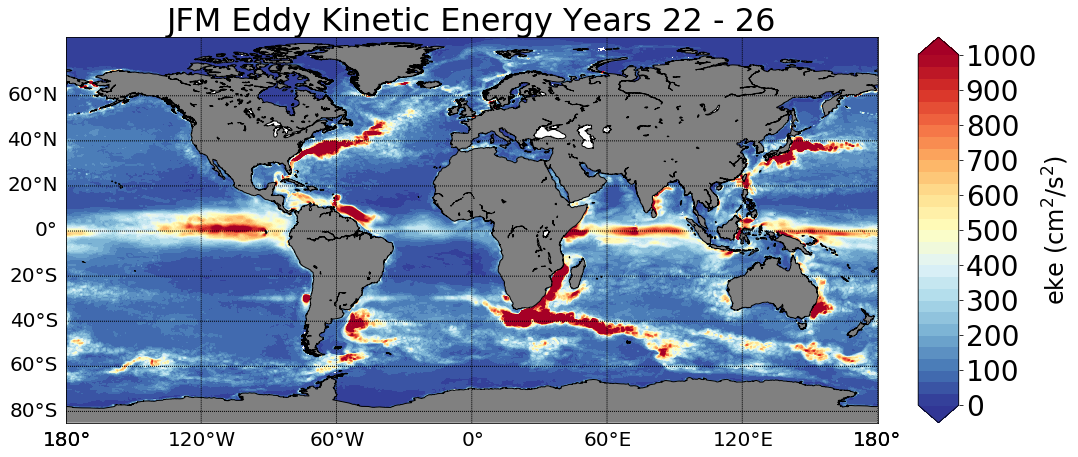

In [63]:
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures

rtd = 180./np.pi
nskip = 5

mpasField = (ds.timeMonthly_avg_velocityZonalSquared[0,0,:,:].values - ds.timeMonthly_avg_velocityZonal[0,0,:,:].values**2 + \
        ds.timeMonthly_avg_velocityMeridionalSquared[0,0,:,:].values - ds.timeMonthly_avg_velocityMeridional[0,0,:,:].values**2)/2.

mpasField *= 1e4

cLabel = r'eke (cm$^2$/s$^2$)'
minval = 0
maxval = 1000

title = season.upper()+' Eddy Kinetic Energy Years {:02d} - {:02d}'.format(start,end)
field = mpasField 
    
fig = plt.figure()

m = Basemap(projection='cyl', llcrnrlat=-85, urcrnrlat=86, llcrnrlon=-180,
                        urcrnrlon=180, resolution='l')
x, y = m(ds.lon_bnds[:,0].values, ds.lat_bnds[:,0].values)  # compute map proj coordinates
xx, yy = meshgrid(x, y)

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='white')
m.drawparallels(np.arange(-80., 80., 20.),fontsize=20,
                labels=[True, False, False, False]);
m.drawmeridians(np.arange(-180., 180., 60.),fontsize=20,
                labels=[False, False, False, True]);
    
if abs(maxval) > 10:
    rspot = -1
elif abs(maxval) > 1:
    rspot = 0
else:
    rspot = 2

minval = round(minval, rspot)
maxval = round(maxval, rspot)

levbounds = np.linspace(minval,maxval,31)
tickbounds = np.linspace(minval,maxval,11)
#for i in range(len(tickbounds)):
#    tickbounds[i] = round(tickbounds[i],rspot)

cs = m.contourf(xx,yy,field,levels=levbounds,cmap='RdYlBu_r',extend='both');
cbar = m.colorbar(cs, location='right', pad="5%", spacing='uniform', \
                 ticks=tickbounds, boundaries=levbounds)
cbar.set_label(cLabel,fontsize=24)
plt.title(title,fontsize=32)
#plt.savefig('/home/lvanroe/MLD_JAS_diff.png')

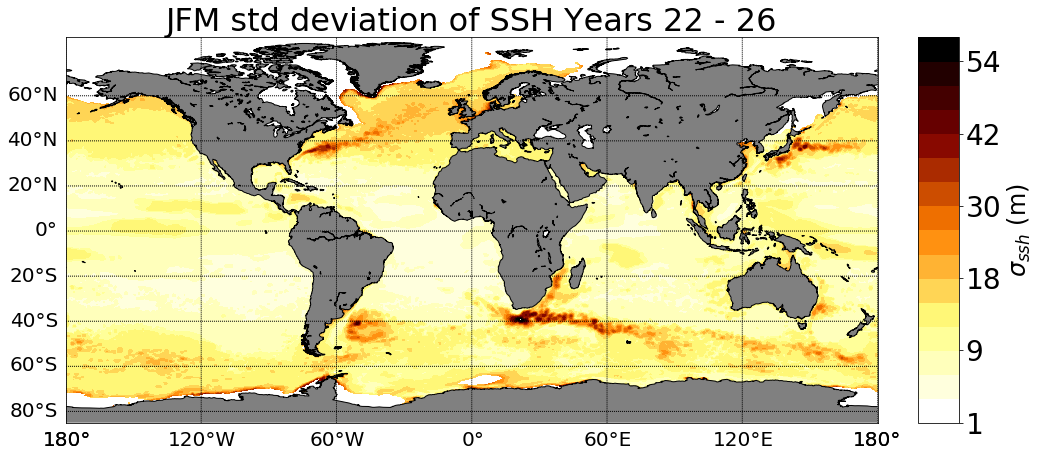

In [64]:
import matplotlib.colors as cols
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures

clevsModelObs = np.asarray([1,3,6,9,10,14,18,22,26,30,34,38,42,46,50,54,58])
cmapModelObs = plt.cm.afmhot_r
cmapModelObs.set_bad('k', 1.0)
norms = cols.BoundaryNorm(clevsModelObs, cmapModelObs.N)

rtd = 180./np.pi
nskip = 5

mpasField = 100*np.sqrt(ds.timeMonthly_avg_SSHSquared[0,:,:].values - ds.timeMonthly_avg_ssh[0,:,:].values**2)


cLabel = r'$\sigma_{ssh}$ (m)'
minval = 0
maxval = 0.5
title = season.upper()+r' std deviation of SSH Years {:02d} - {:02d}'.format(start,end)
field = mpasField 
    
fig = plt.figure()

m = Basemap(projection='cyl', llcrnrlat=-85, urcrnrlat=86, llcrnrlon=-180,
                        urcrnrlon=180, resolution='l')
x, y = m(ds.lon_bnds[:,0].values, ds.lat_bnds[:,0].values)  # compute map proj coordinates
xx, yy = meshgrid(x, y)

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='white')
m.drawparallels(np.arange(-80., 80., 20.),fontsize=20,
                labels=[True, False, False, False]);
m.drawmeridians(np.arange(-180., 180., 60.),fontsize=20,
                labels=[False, False, False, True]);
    
if abs(maxval) > 10:
    rspot = -1
elif abs(maxval) > 1:
    rspot = 0
else:
    rspot = 2

minval = round(minval, rspot)
maxval = round(maxval, rspot)

levbounds = np.linspace(minval,maxval,31)
tickbounds = np.linspace(minval,maxval,11)
#for i in range(len(tickbounds)):
#    tickbounds[i] = round(tickbounds[i],rspot)

cs = m.contourf(xx,yy,field*iceMask,levels=clevsModelObs,norm=norms,cmap=cmapModelObs);
cbar = m.colorbar(cs, location='right', pad="5%", spacing='uniform', \
                 ticks=clevsModelObs[::3], boundaries=clevsModelObs)
cbar.set_label(cLabel,fontsize=24)
plt.title(title,fontsize=32)
#plt.savefig('/home/lvanroe/MLD_JAS_diff.png')